In [18]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from fund.fund import Fund

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [19]:
start = datetime(2012,1,1)
end  = datetime(2020,1,1)
current_date = datetime(2023,1,1)

In [20]:
market = Market()

In [21]:
delta_fund = Fund(start,end,current_date)
delta_fund.initialize()

In [23]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [24]:
analysis = []
for strategy in tqdm(delta_fund.strategies):
    try:
        parameters = strategy.pull_iterations().to_dict("records")
        for parameter in tqdm(parameters):
            try:
                trade = strategy.db.query("trades",{"iteration":parameter["iteration"]})
                if trade.index.size > 0:
                    positions = int(strategy.positions) if strategy.pricer_class.asset_class.value == "stocks" else 1
                    pricer_timeframe =  strategy.pricer_class.time_horizon_class.naming_convention
                    trade = trade[trade["position"] <= positions]
                    ledger = trade.sort_values("date").copy()
                    ledger = ledger[(ledger["date"]>=start) & (ledger["date"]<=end)]
                    anas = strategy.analysis
                    if ledger.index.size > 0:
                        cumulative = anas.trade_analysis(ledger,positions)
                        for key in parameter.keys():
                            cumulative[key] = parameter[key]
                        cumulative["strategy"] = strategy.name
                        analysis.append(cumulative[list(parameter.keys()) + ["strategy","pv"]].iloc[-1])
            except Exception as e:
                print(str(e))
                continue
        strategy.db.disconnect()
    except Exception as e:
        print(str(e))
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:17<00:00,  3.72it/s]

  5%|████████▊                                                                                                                                                                                   | 3/64 [00:01<00:18,  3.28it/s]


 22%|████████████████████████████████████████▉                                                                                                                                                  | 14/64 [00:01<00:03, 13.21it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 14.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 42.00it/s]

  2%|██▉                                                                                                                                                                                         | 1/64 [00:00<00:34,  1.83it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:08<00:00,  7.24it/s]

 41%|███████████████████████████████████████████████████████████████████████████▉                                                                                                               | 26/64 [00:07<00:10,  3.50it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 14.07it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 61/64 [00:04<00:00, 15.47it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 41.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:24<00:00, 14.07s/it]


In [25]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,floor,buy_day,iteration,strategy,pv
525,True,10,False,False,-10,1,13,strategy_wswp_qsrc_qsrr_b_r,10.037593
526,True,1,False,False,0,1,14,strategy_wswp_qsrc_qsrr_b_r,10.037593
543,True,10,False,False,0,1,31,strategy_wswp_qsrc_qsrr_b_r,10.037593
542,True,1,False,False,0,1,30,strategy_wswp_qsrc_qsrr_b_r,10.037593
541,True,10,False,False,-10,1,29,strategy_wswp_qsrc_qsrr_b_r,10.037593
540,True,1,False,False,-10,1,28,strategy_wswp_qsrc_qsrr_b_r,10.037593
524,True,1,False,False,-10,1,12,strategy_wswp_qsrc_qsrr_b_r,10.037593
527,True,10,False,False,0,1,15,strategy_wswp_qsrc_qsrr_b_r,10.037593
375,False,10,True,False,0,1,55,strategy_qsrp_qsrc_qsrr_b_r,9.278610
373,False,10,True,False,-10,1,53,strategy_qsrp_qsrc_qsrr_b_r,9.278610


In [26]:
top_by_strategy = a[a["rank"]==False].sort_values("pv",ascending=False).groupby("strategy").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,strategy,value,ceiling,classification,rank,floor,buy_day,iteration,pv
11,strategy_wswp_qsrc_qsrr_b_r,True,10,False,False,-10,1,29,10.037593
5,strategy_qsrp_qsrc_qsrr_b_r,False,10,True,False,-10,1,53,9.278610
6,strategy_qswp_qsrc_qser_b_r,False,10,False,False,-10,1,45,7.763541
4,strategy_qsrp_qsrc_qser_b_r,False,10,True,False,-10,1,53,7.487839
10,strategy_wswp_qsrc_qser_b_r,True,1,False,False,-10,1,12,6.497480
7,strategy_qswp_qsrc_qsrr_b_r,False,1,False,False,-10,1,44,6.311909
9,strategy_wsrp_qsrc_qsrr_b_r,True,10,False,False,0,1,31,5.915692
8,strategy_wsrp_qsrc_qser_b_r,True,10,False,False,0,1,31,5.546431
2,strategy_dswp_qsrc_qser_b_r,True,1,True,False,-10,1,20,5.047371
3,strategy_dswp_qsrc_qsrr_b_r,True,1,True,False,0,1,6,4.616781


In [27]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["strategy"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [28]:
cumulatives = []
ledgers = []
for row in top_by_strategy.iterrows():
    name = row[1]["strategy"]
    iteration = row[1]["iteration"]
    db = ADatabase(name)
    db.connect()
    analysis = db.query("trades",{"iteration":int(iteration)})
    db.disconnect()
    ledger = analysis[["date","ticker","actual_returns","position"]]
    ledger = ledger[(ledger["date"]>=start) & (ledger["date"]<=end)]
    ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")
    ledger["strategy"] = name
    ledgers.append(ledger)
    portfolio = ledger.pivot_table(index="date",columns="position",values="actual_returns").fillna(1).reset_index()
    positions = ledger["position"].max()
    cumulative = anas.iteration_analysis(portfolio,positions)
    cumulative["strategy"] = name
    cumulatives.append(cumulative)

In [29]:
portfolio = pd.concat(cumulatives).pivot_table(index="date",columns="strategy",values="pv").fillna(method="ffill").fillna(1).reset_index()

In [30]:
portfolio["pv"] = [sum([row[1][strategy]*(1/top_by_strategy.index.size) for strategy in portfolio.columns if strategy not in ["date"]]) for row in portfolio.iterrows()]

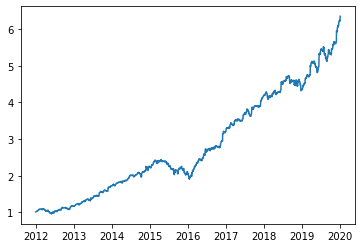

In [31]:
plt.plot(portfolio["date"],portfolio["pv"])

In [32]:
portfolio[["date","pv"]].tail(1)

strategy,date,pv
2011,2019-12-31,6.353724


In [33]:
all_ledgers = pd.concat(ledgers)

In [34]:
all_ledgers.groupby(["strategy","GICS Sector"]).mean().reset_index().sort_values("actual_returns",ascending=False)

,strategy,GICS Sector,actual_returns,position
84,strategy_qswp_qsrc_qsrr_b_r,Real Estate,1.193411,8.000000
73,strategy_qswp_qsrc_qser_b_r,Real Estate,1.193411,7.000000
64,strategy_qswp_qsrc_qser_b_r,Communication Services,1.164695,3.714286
75,strategy_qswp_qsrc_qsrr_b_r,Communication Services,1.155978,4.523810
68,strategy_qswp_qsrc_qser_b_r,Financials,1.112985,4.500000
...,...,...,...,...
89,strategy_wsrp_qsrc_qser_b_r,Energy,0.998206,5.324390
107,strategy_wsrp_qsrc_qsrr_b_r,Utilities,0.997493,5.765101
96,strategy_wsrp_qsrc_qser_b_r,Utilities,0.997187,5.506757
77,strategy_qswp_qsrc_qsrr_b_r,Consumer Staples,0.981870,4.769231
